2D Spinful Fermi Hubbard model

In [18]:
import os
os.environ["NUMBA_NUM_THREADS"] = "20"

import netket as nk
import netket.experimental as nkx
import jax

from math import pi

from netket.experimental.operator.fermion import destroy as c
from netket.experimental.operator.fermion import create as cdag
from netket.experimental.operator.fermion import number as nc

from vmc_torch.fermion_utils import generate_random_fpeps, u1peps_to_z2peps
import quimb.tensor as qtn
import symmray as sr
import pickle

# Define the lattice shape
Lx = 3
Ly = 2
spinless = False
# graph = nk.graph.Square(L)
graph = nk.graph.Grid([Lx,Ly], pbc=False)
N = graph.n_nodes

# Define the fermion filling and the Hilbert space
N_f = int(Lx*Ly)
n_fermions_per_spin = (N_f//2, N_f//2)
hi = nkx.hilbert.SpinOrbitalFermions(N, s=1/2, n_fermions_per_spin=n_fermions_per_spin)

# hi.random_state(key=jax.random.PRNGKey(1))  # for reproducibility

# Define the Hubbard Hamiltonian
t = 1.0
U = 8.0
mu = 4.0

H = 0.0
for (i, j) in graph.edges(): # Definition of the Hubbard Hamiltonian
    for spin in (1,-1):
        H -= t * (cdag(hi,i,spin) * c(hi,j,spin) + cdag(hi,j,spin) * c(hi,i,spin))
for i in graph.nodes():
    H += U * nc(hi,i,+1) * nc(hi,i,-1)
    H -= mu * (nc(hi,i,+1) + nc(hi,i,-1))


# Exact diagonalization of the Hamiltonian for benchmark
sp_h = H.to_sparse() # Convert the Hamiltonian to a sparse matrix
from scipy.sparse.linalg import eigsh
eig_vals, eig_vecs = eigsh(sp_h, k=2, which="SA")
E_gs = eig_vals[0]
print("Exact ground state energy per site:", E_gs/N)

Exact ground state energy per site: -4.362965592081734


/tmp/ipykernel_21179/920423626.py:10: DeprecationWarning: netket.experimental.operator.fermion.destroy is deprecated: use netket.operator.fermion.destroy (netket >= 3.13)
  from netket.experimental.operator.fermion import destroy as c
/tmp/ipykernel_21179/920423626.py:11: DeprecationWarning: netket.experimental.operator.fermion.create is deprecated: use netket.operator.fermion.create (netket >= 3.13)
  from netket.experimental.operator.fermion import create as cdag
/tmp/ipykernel_21179/920423626.py:12: DeprecationWarning: netket.experimental.operator.fermion.number is deprecated: use netket.operator.fermion.number (netket >= 3.13)
  from netket.experimental.operator.fermion import number as nc
/tmp/ipykernel_21179/920423626.py:30: DeprecationWarning: netket.experimental.hilbert.SpinOrbitalFermions is deprecated: use netket.hilbert.SpinOrbitalFermions (netket >= 3.12)
  hi = nkx.hilbert.SpinOrbitalFermions(N, s=1/2, n_fermions_per_spin=n_fermions_per_spin)


In [ ]:
# SU in quimb
D = 4
seed = 0
symmetry = 'U1U1'
spinless = False
peps = generate_random_fpeps(Lx, Ly, D=D, seed=seed, symmetry=symmetry, Nf=N_f, spinless=spinless)[0]
edges = qtn.edges_2d_square(Lx, Ly, cyclic=False)
try:
    parse_edges_to_site_info = sr.utils.parse_edges_to_site_info
except AttributeError:
    parse_edges_to_site_info = sr.parse_edges_to_site_info
site_info = parse_edges_to_site_info(
    edges,
    D,
    phys_dim=4,
    site_ind_id="k{},{}",
    site_tag_id="I{},{}",
)

t = 1.0
U = 8.0
if N_f == int(Lx*Ly-2) or N_f == int(Lx*Ly-8):
    mu = 0.0 if symmetry in ['U1', 'U1U1'] else (U*N_f/(2*N)-2.42)#(U*N_f/(2*N)-2.3)
elif N_f == int(Lx*Ly):
    mu = 0.0 if symmetry in ['U1', 'U1U1'] else (U/2)
elif N_f == int(Lx*Ly-4):
    mu = 0.0 if symmetry in ['U1', 'U1U1'] else (U/2)-U*0.3
else:
    mu = 0.0

print(mu)

terms = {
    (sitea, siteb): sr.fermi_hubbard_local_array(
        t=t, U=U, mu=mu,
        symmetry=symmetry,
        coordinations=(
            site_info[sitea]['coordination'],
            site_info[siteb]['coordination'],
        ),
    )
    for (sitea, siteb) in peps.gen_bond_coos()
}
N_terms = {
    site: sr.fermi_number_operator_spinful_local_array(
        symmetry=symmetry
    )
    for site in peps.gen_site_coos()
}
occ_fn = lambda su: print(f'N per site:{su.get_state().compute_local_expectation(N_terms, normalized=True, max_bond=64,)/N}') if su.n%50==0 else None

ham = qtn.LocalHam2D(Lx, Ly, terms)

su = qtn.SimpleUpdateGen(peps, ham, compute_energy_per_site=True,D=D, compute_energy_opts={"max_distance":1}, gate_opts={'cutoff':1e-12}, callback=occ_fn)

# cluster energies may not be accuracte yet
su.evolve(50, tau=0.3)
# su.evolve(50, tau=0.1)
# su.evolve(50, tau=0.03)
# # su.evolve(50, tau=0.01)
# # su.evolve(50, tau=0.003)

peps = su.get_state()
peps.equalize_norms_(value=1)

# save the state
params, skeleton = qtn.pack(peps)

# import os
# os.makedirs(f'../../data/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}', exist_ok=True)

# with open(f'../../data/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/peps_skeleton.pkl', 'wb') as f:
#     pickle.dump(skeleton, f)
# with open(f'../../data/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/peps_su_params.pkl', 'wb') as f:
#     pickle.dump(params, f)
    

0.0


n=50, tau=0.3, max|dS|=0.16: 100%|##########| 50/50 [00:16<00:00,  4.09it/s]

N per site:1.0000000010075973


n=50, tau=0.3, max|dS|=0.16, energy~-0.291815: 100%|##########| 50/50 [00:24<00:00,  2.08it/s]


In [16]:
# convert to z2 symmetry
fpepsz2 = u1peps_to_z2peps(peps)
params, skeleton = qtn.pack(fpepsz2)

terms_z2 = {
    (sitea, siteb): sr.fermi_hubbard_local_array(
        t=t, U=U, mu=mu,
        symmetry='Z2',
        coordinations=(
            site_info[sitea]['coordination'],
            site_info[siteb]['coordination'],
        ),
    )
    for (sitea, siteb) in peps.gen_bond_coos()
}

N_terms_z2 = {
    site: sr.fermi_number_operator_spinful_local_array(
        symmetry='Z2'
    )
    for site in peps.gen_site_coos()
}
# print(f'N per site:{fpepsz2.compute_local_expectation(N_terms_z2, normalized=True, max_bond=64,)/N}')

import os
os.makedirs(f'../../data/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/Z2/D={D}', exist_ok=True)

with open(f'../../data/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/Z2/D={D}/peps_skeleton.pkl', 'wb') as f:
    pickle.dump(skeleton, f)
with open(f'../../data/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/Z2/D={D}/peps_su_params.pkl', 'wb') as f:
    pickle.dump(params, f)

In [14]:
fpepsz2.compute_local_expectation(terms_z2, normalized=True, max_bond=64,)/N

-0.5580229972511578

In [ ]:
peps.compute_local_expectation(terms, normalized=True, max_bond=64,)/N + mu*0.875 # -0.5581074029856936 for z2peps

-0.5581074029856936

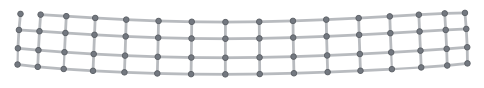

In [48]:
from vmc_torch.hamiltonian import spinful_Fermi_Hubbard_square_lattice
n_fermions_per_spin = (N_f//2, N_f//2)
H = spinful_Fermi_Hubbard_square_lattice(Lx, Ly, t, U, N_f, pbc=False, n_fermions_per_spin=n_fermions_per_spin)
hi = H.hilbert
import numpy as np
rkey = np.random.randint(2**32)
rconfig = hi.random_state(rkey)
amp = su.state.get_amp(rconfig)
amp.draw()

In [2]:
-1.61395+(U*N_f/(2*N)-2.3)*0.875, -1.62679+(U*N_f/(2*N)-2.3)*0.875

(-0.5639499999999997, -0.5767899999999997)

1D Spinful Fermi Hubbard model

In [3]:
import os
os.environ["NUMBA_NUM_THREADS"] = "20"

import netket as nk
import netket.experimental as nkx
import netket.nn as nknn

from math import pi

from netket.experimental.operator.fermion import destroy as c
from netket.experimental.operator.fermion import create as cdag
from netket.experimental.operator.fermion import number as nc

from vmc_torch.fermion_utils import generate_random_fmps
import quimb.tensor as qtn
import symmray as sr
import pickle

# Define the lattice shape
L = 10 # length of the chain
spinless = False
cyclic = False
# graph = nk.graph.Square(L)
graph = nk.graph.Chain(L, pbc=cyclic)
N = graph.n_nodes

# Define the fermion filling and the Hilbert space
N_f = int(L-2)
n_fermions_per_spin = (N_f//2, N_f//2)
hi = nkx.hilbert.SpinOrbitalFermions(N, s=1/2, n_fermions_per_spin=n_fermions_per_spin)

# Define the Hubbard Hamiltonian
t = 1.0
U = 8.0
mu = 0.0

H = 0.0
for (i, j) in graph.edges(): # Definition of the Hubbard Hamiltonian
    for spin in (1,-1):
        H -= t * (cdag(hi,i,spin) * c(hi,j,spin) + cdag(hi,j,spin) * c(hi,i,spin))
for i in graph.nodes():
    H += U * nc(hi,i,+1) * nc(hi,i,-1)


# Exact diagonalization of the Hamiltonian for benchmark
sp_h = H.to_sparse() # Convert the Hamiltonian to a sparse matrix
from scipy.sparse.linalg import eigsh
eig_vals, eig_vecs = eigsh(sp_h, k=2, which="SA")
E_gs = eig_vals[0]
print("Exact ground state energy per site:", E_gs/N)

# fMPS spinful
D = 8
symmetry = 'U1'
seed = 2
# SU in quimb
fmps, charge_config = generate_random_fmps(L, D, seed, symmetry, Nf=N_f, cyclic=cyclic, spinless=spinless)
edges = qtn.edges_1d_chain(L, cyclic=False)

try:
    parse_edges_to_site_info = sr.utils.parse_edges_to_site_info
except AttributeError:
    parse_edges_to_site_info = sr.parse_edges_to_site_info

site_info = parse_edges_to_site_info(
    edges,
    D,
    phys_dim=2 if spinless else 4,
    site_ind_id="k{}",
    site_tag_id="I{}",
)
print(site_info)

terms = {
    (sitea, siteb): sr.fermi_hubbard_local_array(
        t=t, U=U, mu=mu,
        symmetry=symmetry,
        coordinations=(
            site_info[sitea]['coordination'],
            site_info[siteb]['coordination'],
        ),
    )
    for (sitea, siteb) in fmps.gen_bond_coos()
}
ham = qtn.LocalHam1D(L, terms, cyclic=False)

su = qtn.SimpleUpdateGen(
    fmps, 
    ham, 
    compute_energy_per_site=True,
    compute_energy_every=10, 
    D=D, 
    gate_opts={'cutoff':1e-10}
)

# cluster energies may not be accuracte yet
su.evolve(50, tau=0.3)
su.evolve(50, tau=0.1)
su.evolve(50, tau=0.03)
su.evolve(50, tau=0.01)
# su.evolve(100, tau=0.003)

mps = su.get_state()
mps.equalize_norms_(value=1)

# save the state
params, skeleton = qtn.pack(mps)

import os
pwd = '/home/sijingdu/TNVMC/VMC_code/vmc_torch/data'
os.makedirs(pwd+f'/L={L}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}', exist_ok=True)

with open(pwd+f'/L={L}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/mps_skeleton.pkl', 'wb') as f:
    pickle.dump(skeleton, f)
with open(pwd+f'/L={L}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/mps_su_params.pkl', 'wb') as f:
    pickle.dump(params, f)

Exact ground state energy per site: -0.5788665537024758
{0: {'inds': ['b0-1', 'k0'], 'duals': [0, 0], 'shape': [8, 4], 'coordination': 1, 'tags': ('I0',)}, 1: {'inds': ['b0-1', 'b1-2', 'k1'], 'duals': [1, 0, 0], 'shape': [8, 8, 4], 'coordination': 2, 'tags': ('I1',)}, 2: {'inds': ['b1-2', 'b2-3', 'k2'], 'duals': [1, 0, 0], 'shape': [8, 8, 4], 'coordination': 2, 'tags': ('I2',)}, 3: {'inds': ['b2-3', 'b3-4', 'k3'], 'duals': [1, 0, 0], 'shape': [8, 8, 4], 'coordination': 2, 'tags': ('I3',)}, 4: {'inds': ['b3-4', 'b4-5', 'k4'], 'duals': [1, 0, 0], 'shape': [8, 8, 4], 'coordination': 2, 'tags': ('I4',)}, 5: {'inds': ['b4-5', 'b5-6', 'k5'], 'duals': [1, 0, 0], 'shape': [8, 8, 4], 'coordination': 2, 'tags': ('I5',)}, 6: {'inds': ['b5-6', 'b6-7', 'k6'], 'duals': [1, 0, 0], 'shape': [8, 8, 4], 'coordination': 2, 'tags': ('I6',)}, 7: {'inds': ['b6-7', 'b7-8', 'k7'], 'duals': [1, 0, 0], 'shape': [8, 8, 4], 'coordination': 2, 'tags': ('I7',)}, 8: {'inds': ['b7-8', 'b8-9', 'k8'], 'duals': [1, 0, 0

n=50, tau=0.3, max|dS|=0.11, energy~-0.573336: 100%|##########| 50/50 [00:01<00:00, 27.15it/s]  
n=100, tau=0.1, max|dS|=0.047, energy~-0.57839: 100%|##########| 50/50 [00:01<00:00, 28.94it/s] 
n=150, tau=0.03, max|dS|=0.0063, energy~-0.570231: 100%|##########| 50/50 [00:01<00:00, 29.10it/s] 
n=200, tau=0.01, max|dS|=0.0028, energy~-0.568124: 100%|##########| 50/50 [00:01<00:00, 29.13it/s] 


Heisenberg model

In [1]:
import quimb.tensor as qtn
import netket as nk
from vmc_torch.hamiltonian import spin_Heisenberg_square_lattice

ndim = 2
Lx = 4
Ly = 4
pbc = False
total_sz = 0.0
print(f"Total Sz = {total_sz}")
D = 4

# Build square lattice with nearest and next-nearest neighbor edges
# lattice = nk.graph.Square(L, max_neighbor_order=1, pbc=False)
# g = lattice = nk.graph.Hypercube(L, ndim, pbc=pbc)
g = lattice = nk.graph.Grid([Lx, Ly], pbc=pbc)
# g = lattice = nk.graph.Pyrochlore([L, L, L], pbc=pbc)

n = lattice.n_nodes
hi = nk.hilbert.Spin(s=1 / 2, total_sz=0.0, N=n)
# Heisenberg with coupling J=1.0 for nearest neighbors
# and J=0.5 for next-nearest neighbors
# H = nk.operator.Ising(hilbert=hi, graph=lattice, J=1.0, h=1.0)
H = nk.operator.Heisenberg(hilbert=hi, graph=lattice, J=1.0, sign_rule=False) # In Netket, the spin operators are Pauli matrices, while in Quimb they are 1/2*Pauli matrices

ham0 = spin_Heisenberg_square_lattice(Lx, Ly, J=1.0, pbc=pbc,total_sz=total_sz)
hi0 = ham0.hilbert

/global/homes/s/sijingdu/VMC/fermion/mpsds/mpsds/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/global/u1/s/sijingdu/VMC/fermion/vmc_torch_experiment/vmc_torch/fermion_utils.py:256: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  new_oddpos = ftsdata.oddpos + (new_oddpos1,) if new_oddpos1 is not () else ftsdata.oddpos
/global/u1/s/sijingdu/VMC/fermion/vmc_torch_experiment/vmc_torch/fermion_utils.py:760: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  new_oddpos1 = FermionicOperator(new_oddpos, dual=True) if new_oddpos is not () else ()
/global/u1/s/sijingdu/VMC/fermion/vmc_torch_experiment/vmc_torch/fermion_utils.py:761: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  new_oddpos = ftsdata.oddpos + (new_oddpos1,) if new_oddpos1 is not () else ftsdata.oddpos


Total Sz = 0.0


In [2]:
# compute the ground-state energy (here we only need the lowest energy, and do not need the eigenstate)
evals = nk.exact.lanczos_ed(H, compute_eigenvectors=False)
exact_gs_energy = evals[0]
print('The exact ground-state energy is E0=',exact_gs_energy)
print(exact_gs_energy/(Lx*Ly)/4)

The exact ground-state energy is E0= -36.75682826077189
-0.5743254415745608


In [6]:
# PEPS tensor network
psi = qtn.PEPS.rand(Lx=Lx, Ly=Ly, bond_dim=D, phys_dim=2) # initialization from PEPS
J=1.0
ham = qtn.ham_2d_heis(Lx=Lx, Ly=Ly, j=J)
su = qtn.tensor_arbgeom_tebd.SimpleUpdateGen(
    psi, 
    ham,
    compute_energy_every=10,
    compute_energy_per_site=True,
)
for tau in [1.0, 0.3]:#, 0.1, 0.03, 0.01]:
    su.evolve(100, tau=tau)
psi_su = su.state
peps = su.get_state()
peps.equalize_norms_(value=1)

# save the state
params, skeleton = qtn.pack(peps)

import os
import pickle
pwd = '/pscratch/sd/s/sijingdu/VMC/fermion/data'
os.makedirs(pwd+f'/{Lx}x{Ly}/J={J}/D={D}', exist_ok=True)

with open(pwd+f'/{Lx}x{Ly}/J={J}/D={D}/peps_skeleton.pkl', 'wb') as f:
    pickle.dump(skeleton, f)
with open(pwd+f'/{Lx}x{Ly}/J={J}/D={D}/peps_su_params.pkl', 'wb') as f:
    pickle.dump(params, f)
    

n=100, tau=1, max|dS|=0.28, energy~-0.406991: 100%|##########| 100/100 [00:01<00:00, 51.82it/s]
n=200, tau=0.3, max|dS|=0.13, energy~-0.495905: 100%|##########| 100/100 [00:02<00:00, 45.40it/s]


J1-J2 model

In [4]:
import torch
print(torch.cuda.is_available())
import quimb.tensor as qtn
import quimb as qu

import netket as nk
from netket.graph import Lattice
from vmc_torch.hamiltonian import spin_Heisenberg_square_lattice
import numpy as np
from math import pi
from autoray import do

ndim = 2
Lx = 10
Ly = 10
# L = 4
pbc = False
total_sz = 0.0
print(f"Total Sz = {total_sz}")
D = 3

basis = np.array([
     [1.0,0.0],
     [0.0,1.0],
 ])
custom_edges = [
     (0, 0, [1.0,0.0], 0),
     (0, 0, [0.0,1.0], 0),
     (0, 0, [1.0, 1.0], 1),
     (0, 0, [1.0, -1.0], 1),
 ]

g = Lattice(basis_vectors=basis, pbc=False, extent=[Lx, Ly],
     custom_edges=custom_edges)

n = g.n_nodes
hi = nk.hilbert.Spin(s=1/2, total_sz=0.0, N=n)
# Heisenberg with coupling J=1.0 for nearest neighbors
# and J=0.5 for next-nearest neighbors
H = nk.operator.Heisenberg(hilbert=hi, graph=g, J=(1.0,0.5)) # In Netket, the spin operators are Pauli matrices, while in Quimb they are 1/2*Pauli matrices

# # compute the ground-state energy (here we only need the lowest energy, and do not need the eigenstate)
# evals = nk.exact.lanczos_ed(H, compute_eigenvectors=False)
# exact_gs_energy = evals[0]
# print('The exact ground-state energy is E0=',exact_gs_energy)
# print(exact_gs_energy/(Lx*Ly)/4)

# def to_backend(x):
#     # return torch.tensor(x, dtype=torch.float64, device='cuda' if torch.cuda.is_available() else 'cpu')
#     return x
# PEPS tensor network
psi = qtn.PEPS.rand(Lx=Lx, Ly=Ly, bond_dim=D, phys_dim=2) # initialization from PEPS
J1=1.0
J2=0.5
ham = qtn.ham_2d_j1j2(Lx, Ly, j1=J1, j2=J2)
# ham = qtn.ham_2d_heis(Lx=Lx, Ly=Ly, j=1)

# psi.apply_to_arrays(to_backend)
# ham.apply_to_arrays(to_backend)

su = qtn.tensor_2d_tebd.SimpleUpdate(
    psi, 
    ham,
    D=D,
    compute_energy_every=100,
    compute_energy_per_site=True,
)
for tau in [1.0, 0.3, 0.1, 0.03, 0.01]:
    su.evolve(50, tau=tau)
psi_su = su.state

peps = su.get_state()
peps.equalize_norms_(value=1)

# save the state
params, skeleton = qtn.pack(peps)

import os
import pickle
os.makedirs(f'../../data/{Lx}x{Ly}/J1={J1}_J2={J2}/D={D}', exist_ok=True)

with open(f'../../data/{Lx}x{Ly}/J1={J1}_J2={J2}/D={D}/peps_skeleton.pkl', 'wb') as f:
    pickle.dump(skeleton, f)
with open(f'../../data/{Lx}x{Ly}/J1={J1}_J2={J2}/D={D}/peps_su_params.pkl', 'wb') as f:
    pickle.dump(params, f)

False
Total Sz = 0.0


n=250, tau=0.01, energy~-0.317036: 100%|##########| 50/50 [00:14<00:00,  3.35it/s]


In [17]:
import autoray as ar
arr = psi.arrays[0]
arr.device, do('ones', (10,), like=arr, device='cuda'), ar.infer_backend(arr)

(device(type='cuda', index=0),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64),
 'torch')